In [1]:
from src.combined_processor import CombinedProcessor
from src.eeg_config import EEGConfig
from src.utils import *

import torch
import numpy as np
from torch.utils.data import DataLoader
from moabb.datasets import Lee2019_SSVEP, BI2015b

numexpr.utils - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
numexpr.utils - NumExpr defaulting to 16 threads.


In [2]:
checkpoint_path = f'src/SavedModels/VQVAE_epochs_{epochs}.pt'
vqvae = torch.load(checkpoint_path)
vqvae.eval()

/tmp/ipykernel_3910727/1898469397.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae = torch.load(checkpoint_path)
/home/eric/miniconda3/envs/signals_lab/lib/python3.

VQVAE(
  (Encoder): Encoder(
    (blocks): Sequential(
      (0): Conv1d(32, 8, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Mish()
      (2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Mish()
      (4): ResBlock(
        (conv_1): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv_2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ResBlock(
        (conv_1): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv_2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv1d(16, 128, kernel_size=(1,), stride=(1,))
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (Decoder): Decoder(
    (blocks): Sequential(
      (0): Co

In [3]:
lee_config = EEGConfig(
    dataset=Lee2019_SSVEP(),
    num_channels=32,
    sample_rate=1000,
    sample_duration=4,
    eeg_dim=4096,
    subject_range=(6, 6),
    filter_range=(5, 95),
    channel_range=("Fp1", "PO10")
)
configs = [lee_config]
n_fft = 512

test_set = CombinedProcessor(configs=configs, nperseg = n_fft, noverlap = n_fft/2, window='hann')
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 95 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 95.00 Hz
- Upper transition bandwidth: 23.75 Hz (-6 dB cutoff frequency: 106.88 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 95 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 95.00 Hz
- Upper transition bandwidth: 23.75 Hz (-6 dB cutoff frequency: 106.88 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 95 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 95.00 Hz
- Upper transition bandwidth: 23.75 Hz (-6 dB cutoff frequency: 106.88 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


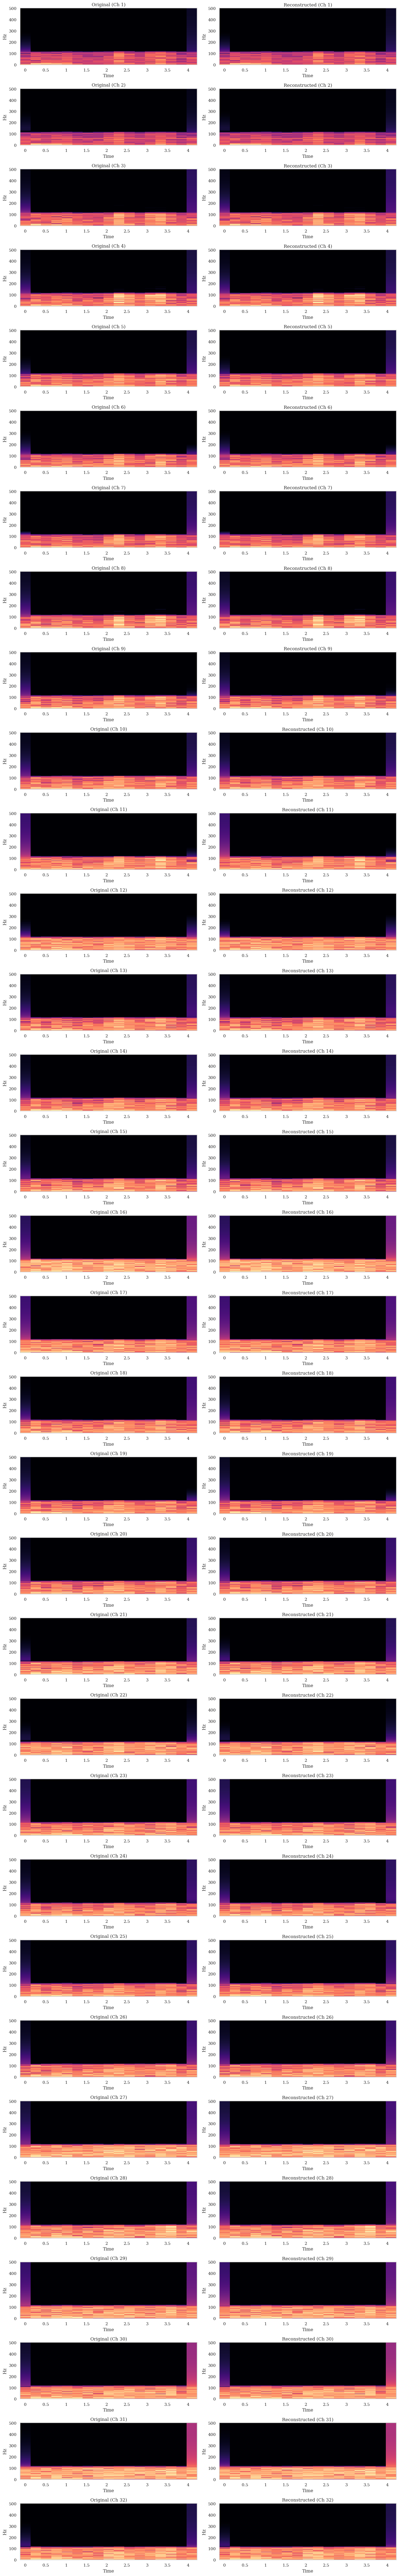

In [4]:
segment = next(iter(test_loader))
original_spectr = test_set.compute_spectrograms(segment.numpy(), 1000)

with torch.no_grad():
    output = vqvae(segment)
    reconstructed_segment = output[0]

reconstructed_spectr = test_set.compute_spectrograms(reconstructed_segment.numpy(), 1000)
original_spectr = np.squeeze(original_spectr)
reconstructed_spectr = np.squeeze(original_spectr)
mse = test_set.compare_spectrograms(original_spectr, reconstructed_spectr)
test_set.plot_spectrograms(
    original=original_spectr,
    reconstructed=reconstructed_spectr,
    mse=mse,
    sample_rate=1000,
    requested_channels=32
)